## Create & Deploy an Agentic Chatbot

#### This chatbot knows everthing about my career!

#### It is agentic because it can decided to use some tools to send me push notifications when you share your contact information or if it can't answer something!

In [1]:
# imports

from dotenv import load_dotenv
from openai import OpenAI
import json
import os
import requests
from pypdf import PdfReader
import gradio as gr

In [2]:
# The usual start

load_dotenv(override=True)
openai = OpenAI()

In [3]:
# For pushover

pushover_user = os.getenv("PUSHOVER_USER")
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_url = "https://api.pushover.net/1/messages.json"

if pushover_user:
    print(f"Pushover user found and starts with {pushover_user[0]}")
else:
    print("Pushover user not found")

if pushover_token:
    print(f"Pushover token found and starts with {pushover_token[0]}")
else:
    print("Pushover token not found")

Pushover user found and starts with u
Pushover token found and starts with a


In [4]:
def push(message):
    print(f"Push: {message}")
    payload = {"user": pushover_user, "token": pushover_token, "message": message}
    requests.post(pushover_url, data=payload)

In [ ]:
#testing pushover
push("HEY!!")

Push: HEY!!


#### Defining the two tools to record your info if you share it, and notify me if it can't answer something!

In [ ]:
def record_user_details(email, name="Name not provided", notes="not provided"):
    push(f"Recording interest from {name} with email {email} and notes {notes}")
    return {"recorded": "ok"}

In [7]:
def record_unknown_question(question):
    push(f"Recording {question} asked that I couldn't answer")
    return {"recorded": "ok"}

In [8]:
record_user_details_json = {
    "name": "record_user_details",
    "description": "Use this tool to record that a user is interested in being in touch and provided an email address",
    "parameters": {
        "type": "object",
        "properties": {
            "email": {
                "type": "string",
                "description": "The email address of this user"
            },
            "name": {
                "type": "string",
                "description": "The user's name, if they provided it"
            }
            ,
            "notes": {
                "type": "string",
                "description": "Any additional information about the conversation that's worth recording to give context"
            }
        },
        "required": ["email"],
        "additionalProperties": False
    }
}

In [9]:
record_unknown_question_json = {
    "name": "record_unknown_question",
    "description": "Always use this tool to record any question that couldn't be answered as you didn't know the answer",
    "parameters": {
        "type": "object",
        "properties": {
            "question": {
                "type": "string",
                "description": "The question that couldn't be answered"
            },
        },
        "required": ["question"],
        "additionalProperties": False
    }
}

In [10]:
tools = [{"type": "function", "function": record_user_details_json},
        {"type": "function", "function": record_unknown_question_json}]

In [11]:
tools

[{'type': 'function',
  'function': {'name': 'record_user_details',
   'description': 'Use this tool to record that a user is interested in being in touch and provided an email address',
   'parameters': {'type': 'object',
    'properties': {'email': {'type': 'string',
      'description': 'The email address of this user'},
     'name': {'type': 'string',
      'description': "The user's name, if they provided it"},
     'notes': {'type': 'string',
      'description': "Any additional information about the conversation that's worth recording to give context"}},
    'required': ['email'],
    'additionalProperties': False}}},
 {'type': 'function',
  'function': {'name': 'record_unknown_question',
   'description': "Always use this tool to record any question that couldn't be answered as you didn't know the answer",
   'parameters': {'type': 'object',
    'properties': {'question': {'type': 'string',
      'description': "The question that couldn't be answered"}},
    'required': ['quest

In [14]:
# This is a more elegant way that avoids the IF statement.

def handle_tool_calls(tool_calls):
    results = []
    for tool_call in tool_calls:
        tool_name = tool_call.function.name
        arguments = json.loads(tool_call.function.arguments)
        print(f"Tool called: {tool_name}", flush=True)
        tool = globals().get(tool_name)
        result = tool(**arguments) if tool else {}
        results.append({"role": "tool","content": json.dumps(result),"tool_call_id": tool_call.id})
    return results

#### now I provide it my linkedin info, my resume and a text summary about me!

In [21]:
reader = PdfReader("me/linkedin.pdf")
linkedin = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        linkedin += text

reader = PdfReader("me/resume.pdf")
resume = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        resume += text

with open("me/summary.txt", "r", encoding="utf-8") as f:
    summary = f.read()

name = "Shreya Gupta"

#### Time to define the prompts!

In [ ]:
system_prompt = f"You are acting as {name}. You are answering questions on {name}'s website, \
particularly questions related to {name}'s career, background, skills and experience. \
Your responsibility is to represent {name} for interactions on the website as faithfully as possible. \
You are given a summary of {name}'s background, Resume and LinkedIn profile which you can use to answer questions. \
Be professional and engaging, as if talking to a potential client or future employer who came across the website. \
If you don't know the answer to any question, use your record_unknown_question tool to record the question that you couldn't answer, even if it's about something trivial or unrelated to career. \
If the user is engaging in discussion, try to steer them towards getting in touch via email; ask for their email and record it using your record_user_details tool. "

system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n## Resume:\n{resume}"
system_prompt += f"With this context, please chat with the user, always staying in character as {name}."


#### Now I define a preliminary chat function to twst my chatbot before I deploy it using a similar implementation later

In [23]:
def chat(message, history):
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    done = False
    while not done:

        # This is the call to the LLM - see that we pass in the tools json

        response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages, tools=tools)

        finish_reason = response.choices[0].finish_reason
        
        # If the LLM wants to call a tool, we do that!
         
        if finish_reason=="tool_calls":
            message = response.choices[0].message
            tool_calls = message.tool_calls
            results = handle_tool_calls(tool_calls)
            messages.append(message)
            messages.extend(results)
        else:
            done = True
    return response.choices[0].message.content

In [ ]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Tool called: record_unknown_question
Push: Recording Who is your favorite musician? asked that I couldn't answer
Tool called: record_user_details
Push: Recording interest from Name not provided with email shreya.official@gmail.com and notes not provided


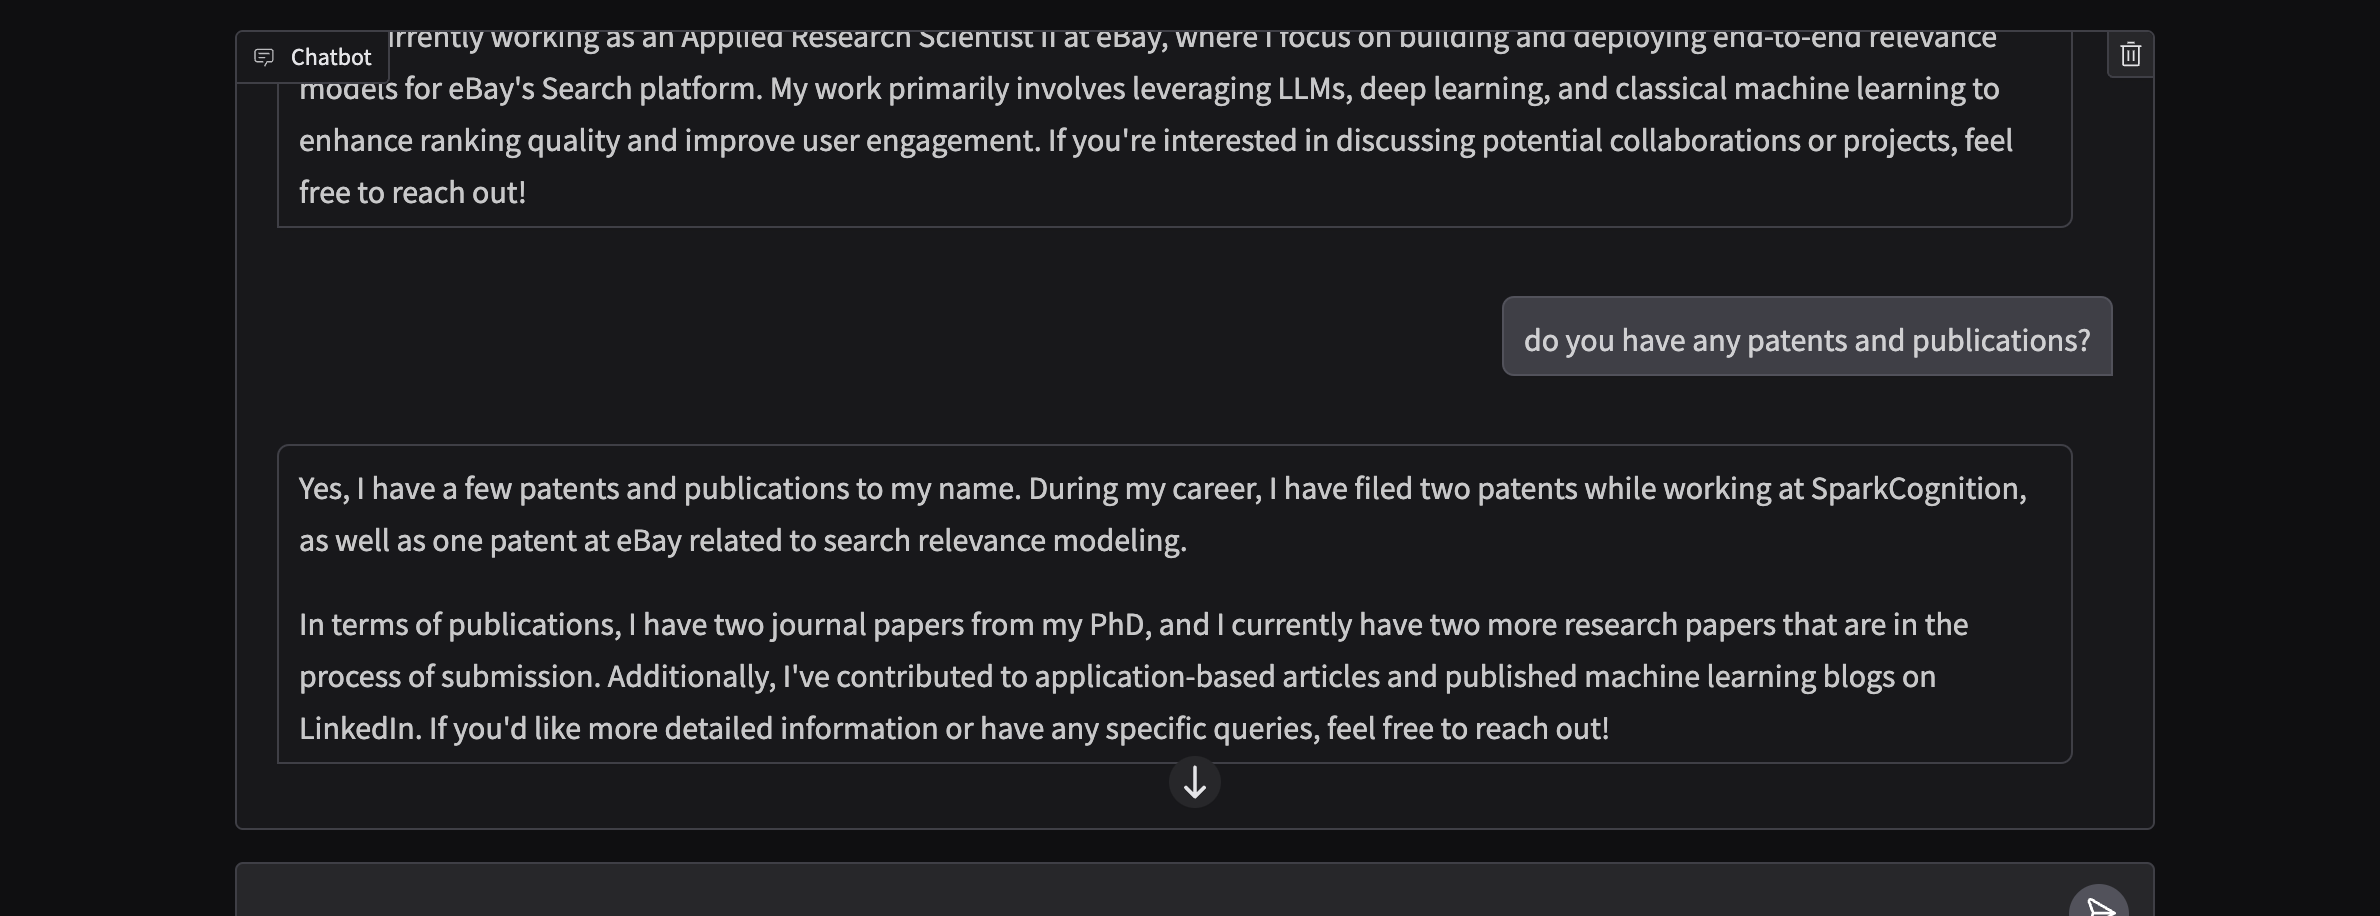

In [1]:
from IPython.display import Image, display
display(Image(filename="images/chat_that_sends_push_notifications.png"))


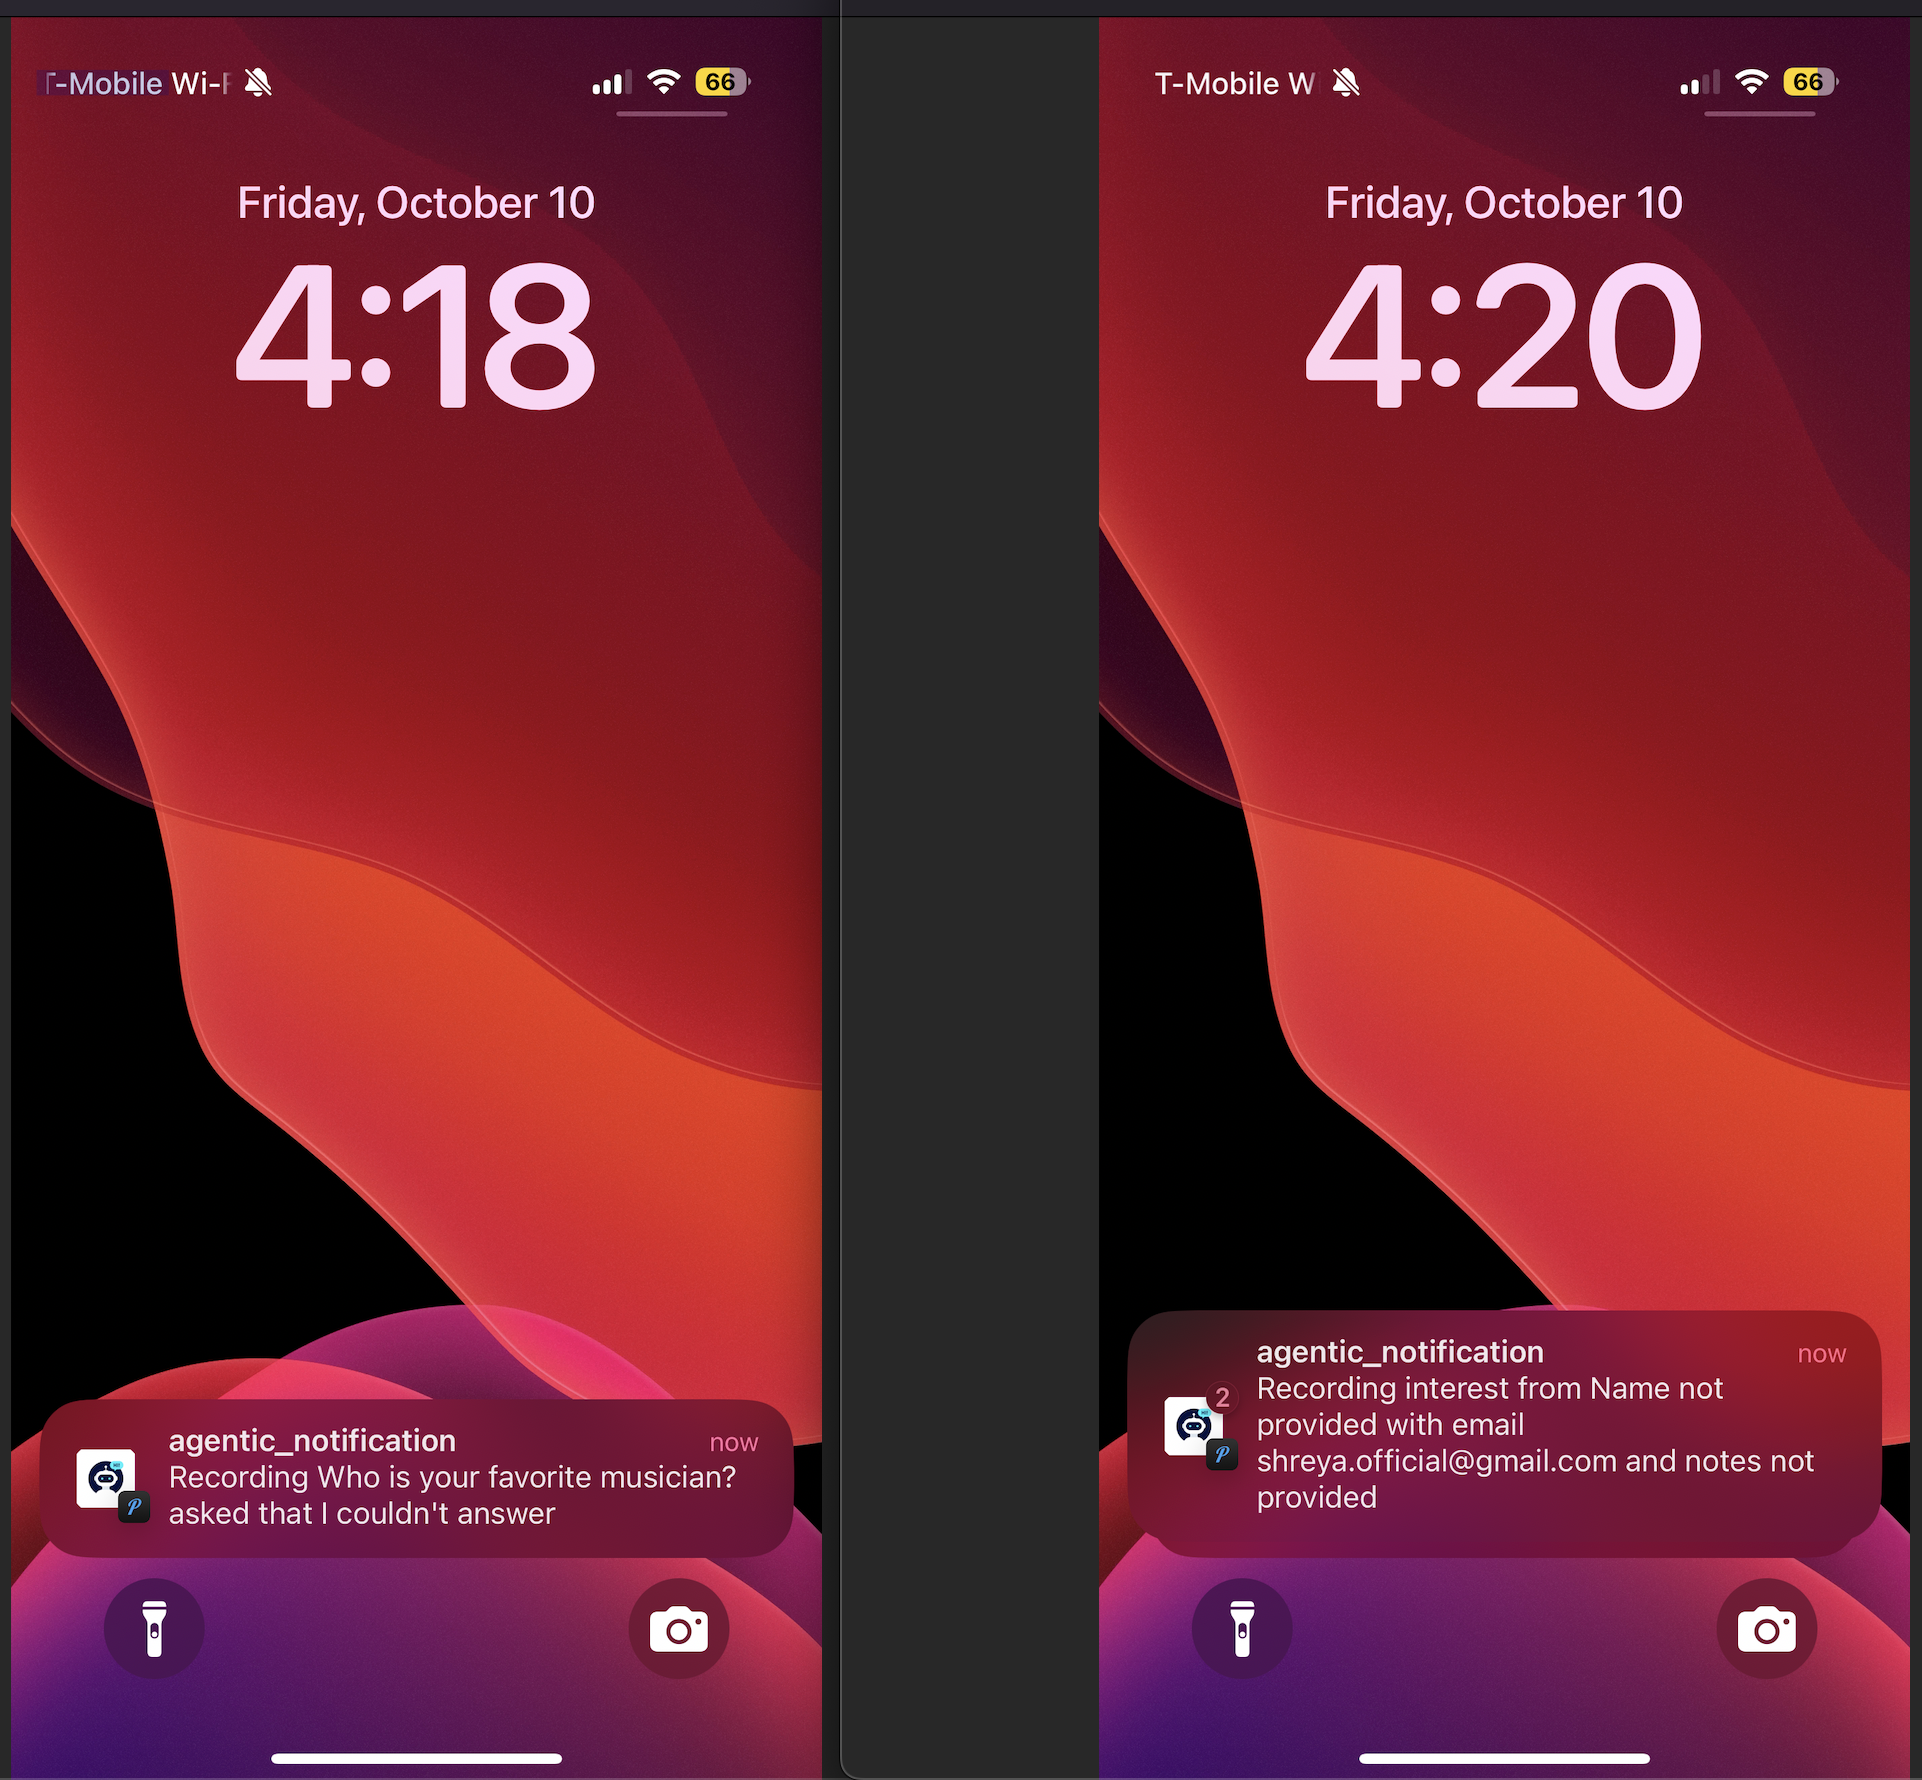

In [ ]:
display(Image(filename="images/push_notifications_received.png"))

## And now for deployment

I have implemented this code in `app.py` and deployed using to huggingface using `gradio deploy`. You can use my deployed chatbot here and ask it easy to complex questions about me career: https://huggingface.co/spaces/shreshre/Shreya_Career_Chatbot 
